In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [335]:
cases = pd.read_csv('data/owid-covid-data.csv')
deaths = pd.read_csv('data/country_ages.csv')
deaths['Value'] = deaths['Value'].apply(lambda x: x.replace(',', ''))
deaths['Value'] = deaths['Value'].apply(lambda x: x.replace(':', ''))
late_dates = ['2021W01', '2021W02', '2021W03', '2021W04', '2021W05']
deaths = deaths[~deaths['TIME'].isin(late_dates)]

inval_groups = ['Total']
deaths_total = deaths[deaths['AGE'].isin(inval_groups)]
deaths = deaths[~deaths['AGE'].isin(inval_groups)]
deaths_total['Value'] = pd.to_numeric(deaths_total['Value'])
deaths['Value'] = pd.to_numeric(deaths['Value'])
deaths.head()
states = deaths.GEO.unique()# states = np.delete(states, np.where(states == 'Italy'))

df = pd.DataFrame({'State': states})
df['Total Deaths'] = df['State'].apply(lambda x: cases[(cases['location'] == x) & (cases['date'] == '2021-01-04')]['total_deaths'].sum())
group_mappings = {
    'Deaths less than 25 years': ['Less than 5 years', 'From 5 to 9 years', 'From 10 to 14 years', 'From 15 to 19 years', 'From 20 to 24 years'],
    'Deaths from 25 to 44 years': ['From 25 to 29 years', 'From 30 to 34 years', 'From 35 to 39 years', 'From 40 to 44 years'],
    'Deaths from 45 to 64 years': ['From 45 to 49 years', 'From 50 to 54 years', 'From 55 to 59 years', 'From 60 to 64 years'],
    'Deaths from 65 to 74 years': ['From 65 to 69 years', 'From 70 to 74 years'],
    'Deaths 75 years and over': ['From 75 to 79 years', 'From 80 to 84 years', 'From 85 to 89 years', '90 years or over']
}
for g in group_mappings:
    df[g] = df['State'].apply(lambda x: deaths[(deaths['GEO'] == x) 
                                               & (deaths['AGE'].isin(group_mappings[g]))]['Value'].sum()
                             * df[df['State'] == x]['Total Deaths'].sum() 
                              / deaths_total[deaths_total['GEO'] == x]['Value'].sum())
    
ifr = {
    25: 0.0000972,
    44: 0.00116,
    64: 0.00939,
    74: 0.0487,
    100: 0.142
}
# df['Total Deaths'] = df.apply(lambda x: x['Deaths less than 25 years']
#                                    + x['Deaths from 25 to 44 years']
#                                    + x['Deaths from 45 to 64 years']
#                                    + x['Deaths from 65 to 74 years']
#                                    + x['Deaths 75 years and over'], axis=1)
# df['Reported Deaths'] = df['State'].apply(lambda x: cases[cases['location'] == x].iloc[0]['Total Deaths'])

df['Calculated Cases'] = df.apply(lambda x: x['Deaths less than 25 years']/ifr[25]
                                   + x['Deaths from 25 to 44 years']/ifr[44]
                                   + x['Deaths from 45 to 64 years']/ifr[64]
                                   + x['Deaths from 65 to 74 years']/ifr[74]
                                   + x['Deaths 75 years and over']/ifr[100]
                                  , axis=1)

In [131]:
eu_data = pd.read_csv('data/agerangenotificationeu.csv')
countries = np.unique(eu_data['country'])
# Brexit, lol
countries = np.append(countries, "United Kingdom")

In [132]:
## First come up with some distance metric for countries using OWID data

owid = pd.read_csv('data/owid-covid-data.csv')
country_states = owid[owid['location'].isin(countries)]
country_states = country_states[country_states['location'].notna()]
df = country_states
df.fillna(method = 'ffill', inplace = True)
country_states = df
group = country_states.groupby(['location'])
snapshot = group.last()

In [133]:
# Grab most similar features that are not directly case-related (this is the outcome we wish to predict)
features = ['reproduction_rate', 'total_tests_per_thousand', 'tests_units', 'population_density', 'median_age',
            'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
            'male_smokers', 'hospital_beds_per_thousand','life_expectancy',
            'human_development_index']
snapshot = pd.DataFrame(snapshot, columns = features)

In [135]:
snapshot.tests_units = pd.Categorical(snapshot.tests_units)
snapshot['tests_units'] = snapshot.tests_units.cat.codes

In [136]:
snapshot = snapshot.drop(['handwashing_facilities'], axis = 1)

In [137]:
## Now we begin the pca clustering and distance metric calculation

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
X = np.array(snapshot)
X = normalize(X)
pca = PCA(n_components = 3)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.58384776 0.30000272 0.11371621]


In [138]:
Xt = pca.fit_transform(X)
reduced_snap = pd.DataFrame(Xt)
reduced_snap.index = snapshot.index.values

In [139]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
a = reduced_snap.values
dist = euclidean_distances(a, a)

In [140]:
for i in range (len(dist)):
    for j in range(len(dist)):
        if i < j and dist[i][j] < 0.001:
            print(snapshot.index.values[i], snapshot.index.values[j])

Czechia Greece
Hungary Slovakia


In [141]:
## Some basic exploration of response measures.

responses = ['BanOnAllEvents', 'StayHomeOrder', 'ClosDaycare', 'ClosHigh', 'NonEssentialShops']

country_responses = pd.read_csv("data/country_response_measures.csv")
country_responses = country_responses[country_responses['Response_measure'].isin(responses)]
country_responses = country_responses.fillna('2020-12-31')

In [142]:
## look at just BanOnAllEvents for now
eventsban = country_responses[country_responses['Response_measure'] == 'StayHomeOrder']

cntrs = np.unique(eventsban['Country'])
idx = np.arange(len(cntrs))

In [143]:
# want to compare countries with SHO against countries without
locked = cntrs
unlocked = [x for x in countries if x not in cntrs]

In [144]:
def find_nearest_non_lockdown_country(country):
    assert (country in locked)
    dist = 1000
    answer = country
    x = reduced_snap.loc[country, :]
    for target in unlocked:
        y = reduced_snap.loc[target, :]
        d = np.linalg.norm(x-y)
        if d < dist:
            dist = d
            answer = target
    return answer

find_nearest_non_lockdown_country("United Kingdom")

'Portugal'

In [104]:
locked

array(['Austria', 'Belgium', 'Cyprus', 'Czechia', 'France', 'Greece',
       'Hungary', 'Ireland', 'Italy', 'Luxembourg', 'Poland', 'Romania',
       'Slovenia', 'Spain', 'United Kingdom'], dtype=object)

In [202]:
# Grab time series from owid

timesrs = owid[owid['location'].isin(countries)]
# Keep the time series consistent in length
min_date = timesrs[timesrs['location'] == 'Austria'] ['date']
timesrs = timesrs[timesrs['date'].isin(min_date)]

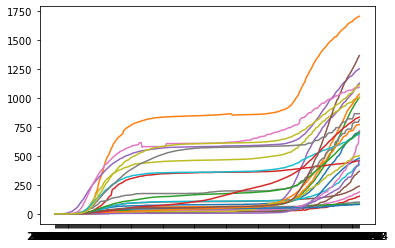

In [203]:
for curr in countries:
    data = timesrs[timesrs['location'] == curr]['total_deaths_per_million'].fillna(0)
    date = timesrs[timesrs['location'] == curr] ['date']
    plt.plot(date, data)
    

In [180]:
min_date = timesrs[timesrs['location'] == 'Austria'] ['date']


2824    2020-02-25
2825    2020-02-26
2826    2020-02-27
2827    2020-02-28
2828    2020-02-29
           ...    
3134    2020-12-31
3135    2021-01-01
3136    2021-01-02
3137    2021-01-03
3138    2021-01-04
Name: date, Length: 315, dtype: object

In [190]:
# Dynamic warping between two time series
reference = np.array(timesrs[timesrs['location'] == 'United Kingdom']['total_deaths'].fillna(0))
query = np.array(timesrs[timesrs['location'] == 'Austria']['total_deaths'].fillna(0))

alignment = dtw(reference, query, keep_internals = True)

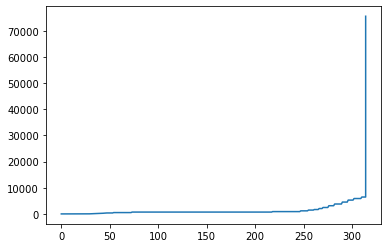

In [195]:
plt.plot(alignment.index2,reference[alignment.index1])

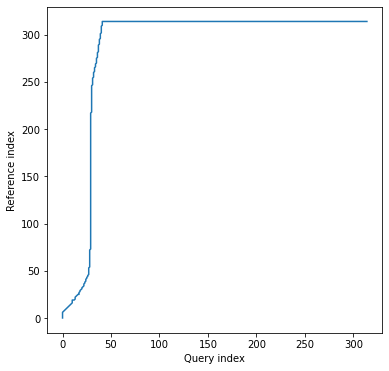

In [194]:
alignment.index1
alignment.plot(type="alignment") 

In [196]:
## New idea, now we do some regression on time series

min_date

2824    2020-02-25
2825    2020-02-26
2826    2020-02-27
2827    2020-02-28
2828    2020-02-29
           ...    
3134    2020-12-31
3135    2021-01-01
3136    2021-01-02
3137    2021-01-03
3138    2021-01-04
Name: date, Length: 315, dtype: object

In [232]:
mobility = pd.read_csv("data/Global_Mobility_Report.csv")
mobility = mobility[mobility['country_region'].isin(countries)]
mobility.tail()

/Users/bguo/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
3054621,SK,Slovakia,Žilina Region,Žilina District,NaN,NaN,NaN,ChIJDWo32mtYFEcRwI6XxtH3AAM,2021-02-08,-57.0,-18.0,2.0,-48.0,-30.0,14.0
3054622,SK,Slovakia,Žilina Region,Žilina District,NaN,NaN,NaN,ChIJDWo32mtYFEcRwI6XxtH3AAM,2021-02-09,-57.0,-12.0,2.0,-46.0,-29.0,14.0
3054623,SK,Slovakia,Žilina Region,Žilina District,NaN,NaN,NaN,ChIJDWo32mtYFEcRwI6XxtH3AAM,2021-02-10,-57.0,-12.0,5.0,-47.0,-28.0,15.0
3054624,SK,Slovakia,Žilina Region,Žilina District,NaN,NaN,NaN,ChIJDWo32mtYFEcRwI6XxtH3AAM,2021-02-11,-57.0,-11.0,-3.0,-46.0,-28.0,14.0
3054625,SK,Slovakia,Žilina Region,Žilina District,NaN,NaN,NaN,ChIJDWo32mtYFEcRwI6XxtH3AAM,2021-02-12,-56.0,-5.0,-5.0,-50.0,-28.0,16.0


In [233]:
mobility_indicators = ['grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline',
                      'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline',
                      'residential_percent_change_from_baseline']
mobility[mobility_indicators] = mobility[mobility_indicators].fillna(0)
mobility = mobility[mobility['date'].isin(date)]
mobility['mob'] = mobility[mobility_indicators].mean(axis = 1)
mobility_time = mobility.groupby(['country_region', 'date'])[['mob']].median()

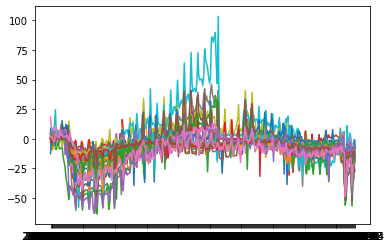

In [244]:
for curr in new_cntrs:
    temp = mobility_time.loc[curr, 'mob']
    plt.plot(min_date, temp)

In [243]:
new_cntrs = mobility_time.index.get_level_values(0)
new_cntrs = np.unique(new_cntrs)
new_cntrs

array(['Austria', 'Belgium', 'Croatia', 'Czechia', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
       'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom'],
      dtype=object)

In [380]:
c = "United Kingdom"
locked = [x for x in locked if x in new_cntrs]
from tslearn.metrics import dtw as dtw_score
scores = {}
for c in new_cntrs:
    # get the deaths time series
    deaths = timesrs[timesrs['location'] == c]['new_deaths_smoothed_per_million'].fillna(0)
    mob = mobility_time.loc[c, "mob"]

    def normalize(timeseries):
        return (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())

    deaths = normalize(deaths)
    mob = normalize(mob)
    sim = dtw_score(deaths, mob)
    scores[c] = sim


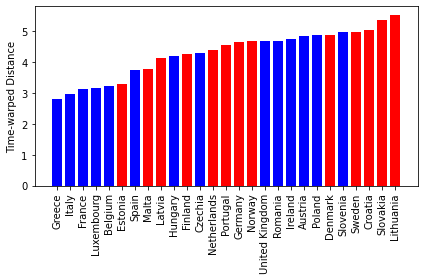

In [328]:
sims = pd.DataFrame(index = scores.keys())
sims['score'] = scores.values()
sims['locked'] = "N"
sims.loc[(sims.index.isin(locked)), 'locked'] = 'Y'
sims = sims.sort_values(['score'], ascending = True)
cmap = ['red' if x == "N" else 'blue' for x in sims['locked']]
plt.bar(range(len(sims)), sims['score'], color = cmap)
plt.xticks(range(len(sims)), list(sims.index), rotation = 90)
plt.ylabel("Time-warped Distance")
plt.tight_layout()
plt.show()

/Users/bguo/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


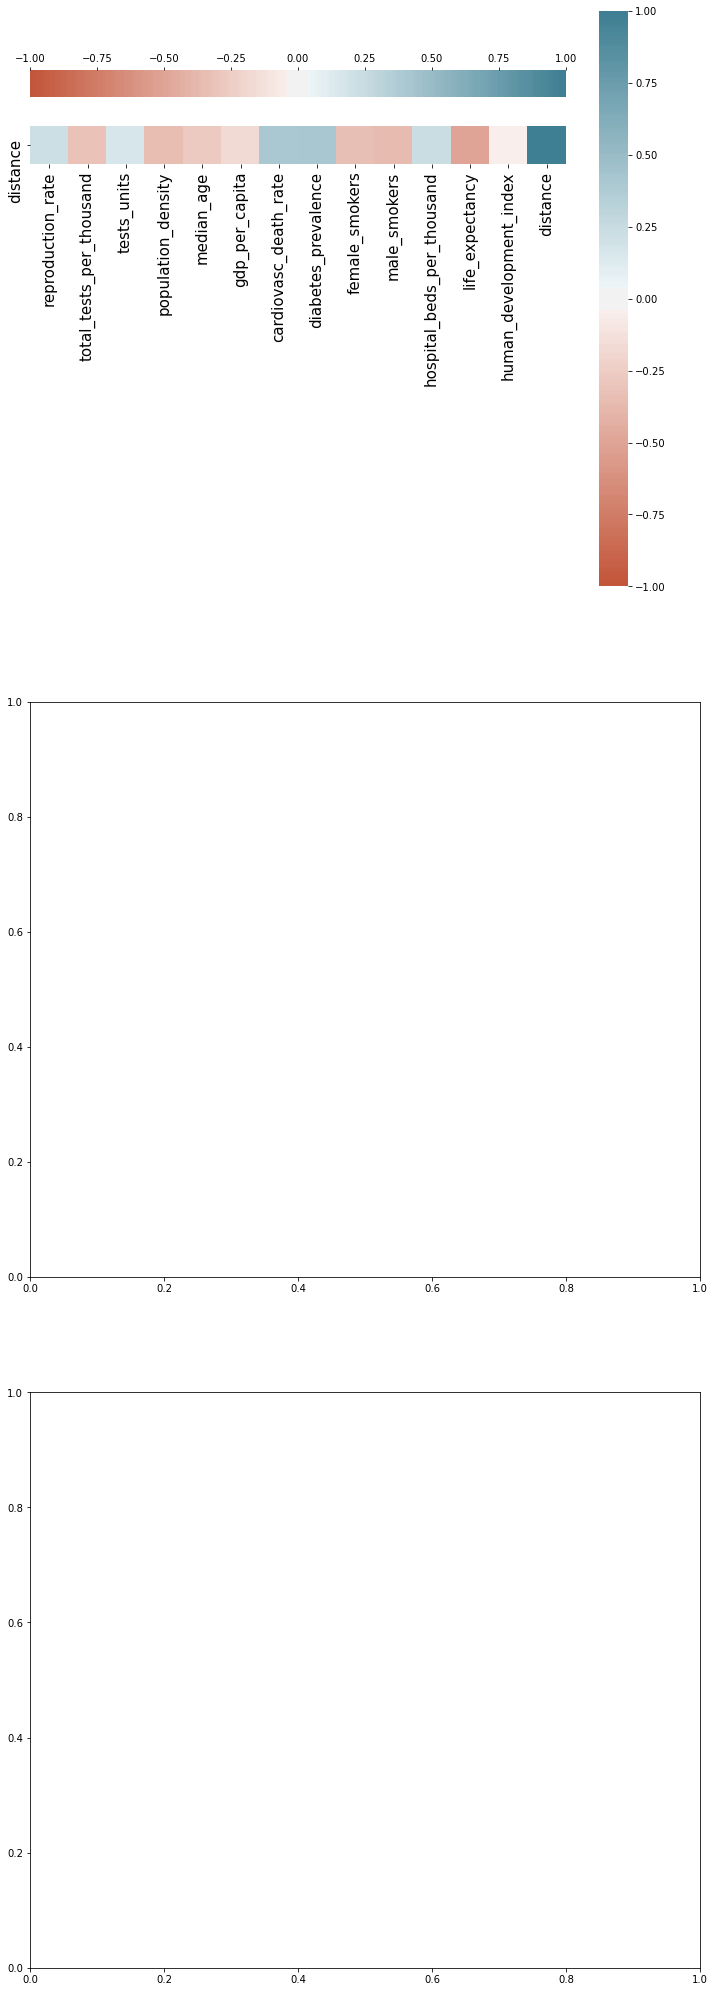

In [368]:
# Correlation matrix between these locked down countries and key features
import seaborn as sns
small_snap = snapshot[snapshot.index.isin(locked)]
vals = []
for c in small_snap.index:
    if c in locked:
        val = scores[c]
        vals.append(val)

small_snap['distance'] = vals  
corr = small_snap.corr()

a4_dims = (12, 36)
fig, ax = plt.subplots(figsize=a4_dims, nrows=3)

sns.heatmap(
    corr, 
    ax=ax[0], 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
x = corr[['distance']]
b = sns.heatmap(
    x.T, 
    ax=ax[0], 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    cbar_kws = dict(use_gridspec=False,location="top")
)
b.tick_params(labelsize=15)

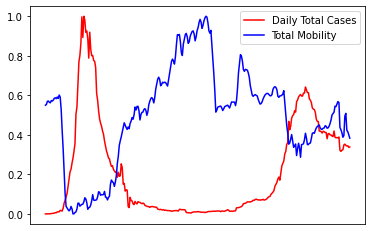

<Figure size 432x288 with 0 Axes>

In [379]:
c = "France"
deaths = timesrs[timesrs['location'] == c]['new_deaths_smoothed_per_million'].fillna(0)
mob = mobility_time.loc[c, "mob"]

mob = pd.Series(mob)
avgs = mob.rolling(5)
mob_avg = avgs.mean()
mob_avg = mob_avg[5:]

def normalize(timeseries):
    return (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())

deaths = normalize(deaths[5:])
mob = normalize(mob_avg)
short = date[5:]
# weird case for greece
#short = short[:-1] 
#mob = mob[:-1]

plt.plot(short, deaths, label = "Daily Total Cases", color = "red")
plt.plot(short, mob, label = "Total Mobility", color = "blue")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend(loc = "upper right")
plt.show()
plt.savefig("figures/italy1.png")

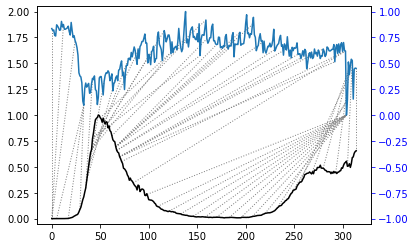

In [381]:
from dtw import *
alignment = dtw(deaths, mob, keep_internals = True)
alignment.plot(type="twoway",offset=1)
